In [1]:
# Necessary imports
import os, cv2, random
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

In [2]:
TRAIN_DIR = 'train/'
TEST_DIR = 'test/'


LABELS = 2 # Number of different types of labels (1-10)
IMAGE_SIZE = 100; # 150x150.  Also, 224, 96, 64, and 32 are also common
CHANNELS = 3
pixel_depth = 255.0  # Number of levels per pixel.
LR = 0.001 # Learning rate

# Load Data
Create a list of test and training images. We share dogs and cats to create a set in which we will share them equally.

In [23]:
TRAINING_AND_VALIDATION_SIZE_DOGS = 1000 #12500
TRAINING_AND_VALIDATION_SIZE_CATS = 1000 #12500
TRAINING_AND_VALIDATION_SIZE_ALL  = 2000 #25000
TEST_SIZE_ALL = 10



train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] 
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

train_images = train_dogs[:TRAINING_AND_VALIDATION_SIZE_DOGS] + train_cats[:TRAINING_AND_VALIDATION_SIZE_CATS]
train_labels_1dim = np.array ((['dogs'] * TRAINING_AND_VALIDATION_SIZE_DOGS) + (['cats'] * TRAINING_AND_VALIDATION_SIZE_CATS))
test_images =  test_images[:TEST_SIZE_ALL]
test_labels = np.array (['unknownclass'] * TEST_SIZE_ALL)

print(train_images[30:50])
test_images

['train/dog.10023.jpg', 'train/dog.10024.jpg', 'train/dog.10025.jpg', 'train/dog.10026.jpg', 'train/dog.10027.jpg', 'train/dog.10028.jpg', 'train/dog.10029.jpg', 'train/dog.1003.jpg', 'train/dog.10030.jpg', 'train/dog.10031.jpg', 'train/dog.10032.jpg', 'train/dog.10033.jpg', 'train/dog.10034.jpg', 'train/dog.10035.jpg', 'train/dog.10036.jpg', 'train/dog.10037.jpg', 'train/dog.10038.jpg', 'train/dog.10039.jpg', 'train/dog.1004.jpg', 'train/dog.10040.jpg']


['test/1.jpg',
 'test/10.jpg',
 'test/100.jpg',
 'test/1000.jpg',
 'test/10000.jpg',
 'test/10001.jpg',
 'test/10002.jpg',
 'test/10003.jpg',
 'test/10004.jpg',
 'test/10005.jpg']

# Data pre-processing
Read the images, reduce them to a size of 100 * 100 and convert them into an array. Normalize our data. 
Reshaping into image shape: (# images, # vertical height, # horizontal width, # colors)


In [24]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    if (img.shape[0] >= img.shape[1]): # height is greater than width
        resizeto = (IMAGE_SIZE, int (round (IMAGE_SIZE * (float (img.shape[1])  / img.shape[0]))));
    else:
        resizeto = (int (round (IMAGE_SIZE * (float (img.shape[0])  / img.shape[1]))), IMAGE_SIZE);
    
    img2 = cv2.resize(img, (resizeto[1], resizeto[0]), interpolation=cv2.INTER_CUBIC)
    img3 = cv2.copyMakeBorder(img2, 0, IMAGE_SIZE - img2.shape[0], 0, IMAGE_SIZE - img2.shape[1], cv2.BORDER_CONSTANT, 0)
        
    return img3[:,:,::-1]  # turn into rgb format

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), dtype=np.float32)

    for i, image_file in enumerate(images):
        image = read_image(image_file);
        image_data = np.array (image, dtype=np.float32);
        image_data[:,:,0] = (image_data[:,:,0].astype(float) - pixel_depth / 2) / pixel_depth
        image_data[:,:,1] = (image_data[:,:,1].astype(float) - pixel_depth / 2) / pixel_depth
        image_data[:,:,2] = (image_data[:,:,2].astype(float) - pixel_depth / 2) / pixel_depth
        
        data[i] = image_data; # image_data.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))    
    return data

train_normalized = prep_data(train_images)
test_normalized = prep_data(test_images)

print("Train shape: {}".format(train_normalized.shape))
print("Train shape: {}".format(test_normalized.shape))



Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
Processed 0 of 10
Train shape: (2000, 100, 100, 3)
Train shape: (10, 100, 100, 3)


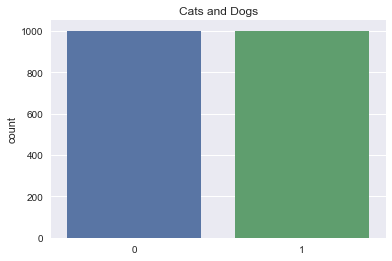

In [67]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)
sns.plt.title('Cats and Dogs')


# Visualize Data


dogs
dogs
dogs


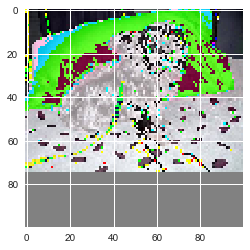

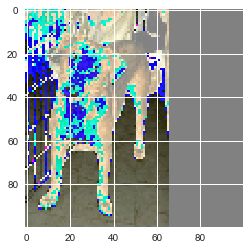

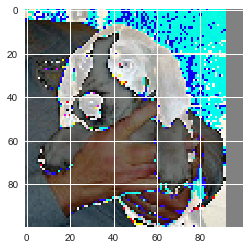

In [26]:
plt.imshow (train_normalized[0,:,:,:])
plt.figure ()
print(train_labels_1dim[0])
plt.imshow (train_normalized[1,:,:,:])
plt.figure ()
print(train_labels_1dim[1])
plt.imshow (train_normalized[2,:,:,:])
plt.figure ()
print(train_labels_1dim[2])


# One Hot Encoder
Convert our tags to one hot encode.

In [27]:
train_labels = LabelEncoder().fit_transform(train_labels_1dim)[:, None]
train_labels = OneHotEncoder().fit_transform(train_labels).todense()
print(train_labels.shape)
print(train_labels[1:10])

(2000, 2)
[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


# Data split
We divide our data into training and testing in the ratio 80/20. Also we mix them

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_normalized, train_labels, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(1280, 100, 100, 3)
(1280, 2)
(400, 100, 100, 3)
(400, 2)
(320, 100, 100, 3)
(320, 2)


# SOLUTION

Let's now build a cnn


**Layer 1:** Convolutional. The output shape should be 100x100x32.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 50x50x32.

**Layer 2:** Convolutional. The output shape should be 50x50x32.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 25x25x32.

**Layer 2:** Convolutional. The output shape should be 25x25x64.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 13x13x64.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. 

**Layer 3:** Fully Connected. This should have 64 outputs.

**Activation.** Your choice of activation function.

**Dropout:** Dropout Layer. 

**Layer 5:** Fully Connected (Logits). This should have 2 outputs.


In [29]:
sess = tf.InteractiveSession()    
def widht_init(shape):
    weight = tf.Variable(tf.truncated_normal(shape,stddev = 0.1))
    return weight

def bias_init(shape):
    bias = tf.Variable(tf.constant(0.1,shape=shape))
    return bias

def conv2d(x,W):
    return tf.nn.conv2d(x,W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')


def model(x,keep_prob):
    #first conv layer
    W1 = widht_init([3,3,3,32])
    b1 = bias_init([32])
    h1_conv = conv2d(x,W1)
    h1_conv = tf.nn.relu(h1_conv+b1)
    h1_conv = max_pool_2x2(h1_conv)
    print(h1_conv.shape)

    #second conv layer
    W2 = widht_init([3,3,32,32])
    b2 = bias_init([32])
    h2_conv = conv2d(h1_conv,W2)
    h2_conv = tf.nn.relu(h2_conv+b2)
    h2_conv = max_pool_2x2(h2_conv)
    print(h2_conv.shape)

    #еhird conv layer
    W3 = widht_init([3,3,32,64])
    b3 = bias_init([64])
    h3_conv = conv2d(h2_conv,W3)
    h3_conv = tf.nn.relu(h3_conv+b3)
    h3_conv = max_pool_2x2(h3_conv)
    print(h3_conv.shape)

    #third conv layer
    #W4 = widht_init([3,3,64,128])
    #b4 = bias_init([128])
    #h4_conv = conv2d(h3_conv,W4)
    #h4_conv = tf.nn.relu(h4_conv+b4)
    #h4_conv = max_pool_2x2(h4_conv)
    #print(h4_conv.shape)

    #W5 = widht_init([3,3,128,256])
    #b5 = bias_init([256])
    #h5_conv = conv2d(h4_conv,W5)
    #h5_conv = tf.nn.relu(h5_conv+b5)
    #h5_conv = max_pool_2x2(h5_conv)
    #print(h5_conv.shape)

    #full conect layer
    values = h3_conv.get_shape().as_list()
    print(values[1],values[2],values[3])
    h3_conv = tf.reshape(h3_conv, (-1, values[1]*values[2]*values[3]))
    print(h3_conv.shape)

    W_fc = widht_init([values[1]*values[2]*values[3],64])
    b_fc = bias_init([64])
    h_fc = tf.nn.relu(tf.matmul(h3_conv,W_fc)+b_fc)
    print(h_fc.shape)

    #dropout layer
    
    h_fc_drop = tf.nn.dropout(h_fc, keep_prob)

    #W_fc1 = widht_init([1024,2])
    #b_fc1 = bias_init([2])
    #h_fc1 = tf.nn.relu(tf.matmul(h_fc_drop,W_fc1)+b_fc1)
    #print(h_fc1.shape)

    #h_fc_drop1 = tf.nn.dropout(h_fc1, keep_prob)

    #output layer
    W_out = widht_init([64,2])
    b_out = bias_init([2])
    y_conv = tf.matmul(h_fc_drop,W_out)+b_out
    print(y_conv.shape)
    return y_conv

# Training Pipeline

In [30]:
BATCH_SIZE = 128
EPOCHS = 40 #80
LR = 0.0001
y_ = tf.placeholder(tf.float32, shape=[None, 2])
x = tf.placeholder(tf.float32, shape=[None,IMAGE_SIZE,IMAGE_SIZE,CHANNELS])
keep_prob = tf.placeholder(tf.float32)
y_conv = model(x,keep_prob)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(LR).minimize(cross_entropy)

(?, 50, 50, 32)
(?, 25, 25, 32)
(?, 13, 13, 64)
13 13 64
(?, 10816)
(?, 64)
(?, 2)


# Model Evaluation
As an estimate, I chose the accuracy
We also declare the safer in order to save the trained weights in the future

In [31]:
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Class used to save and/or restore Tensor Variables
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y_: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


# Train the Model
We divide our data into batches
After each epoch, measure the loss and accuracy of the validation set.

In [32]:
from sklearn.utils import shuffle
session = tf.Session()
history = [(0, np.nan, 10)]
sess.run(tf.global_variables_initializer())
num_examples = len(X_train)
print("Training...")
print()
for i in range(EPOCHS):
    X_train, y_train = shuffle(X_train, y_train)
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_train[offset:end], y_train[offset:end]
        sess.run(train_step, feed_dict={x: batch_x, y_: batch_y , keep_prob: 0.5})
            
    validation_accuracy = evaluate(X_valid, y_valid)
    validation_loss = sess.run(cross_entropy, feed_dict={x: X_valid, y_: y_valid, keep_prob: 1.0})
    print("EPOCH {} ...".format(i+1))
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    print("Validation Loss = {:.3f}".format(validation_loss))
    print()
    history.append((i, validation_loss, validation_accuracy))
        
saver.save(sess, './lenet')
print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.502
Validation Loss = 0.747

EPOCH 2 ...
Validation Accuracy = 0.527
Validation Loss = 0.714

EPOCH 3 ...
Validation Accuracy = 0.507
Validation Loss = 0.697

EPOCH 4 ...
Validation Accuracy = 0.540
Validation Loss = 0.690

EPOCH 5 ...
Validation Accuracy = 0.547
Validation Loss = 0.689

EPOCH 6 ...
Validation Accuracy = 0.525
Validation Loss = 0.689

EPOCH 7 ...
Validation Accuracy = 0.530
Validation Loss = 0.690

EPOCH 8 ...
Validation Accuracy = 0.530
Validation Loss = 0.690

EPOCH 9 ...
Validation Accuracy = 0.527
Validation Loss = 0.686

EPOCH 10 ...
Validation Accuracy = 0.537
Validation Loss = 0.684

EPOCH 11 ...
Validation Accuracy = 0.537
Validation Loss = 0.681

EPOCH 12 ...
Validation Accuracy = 0.555
Validation Loss = 0.681

EPOCH 13 ...
Validation Accuracy = 0.555
Validation Loss = 0.679

EPOCH 14 ...
Validation Accuracy = 0.568
Validation Loss = 0.678

EPOCH 15 ...
Validation Accuracy = 0.565
Validation Loss = 0.677

EPOCH 

# Visualize the training history:


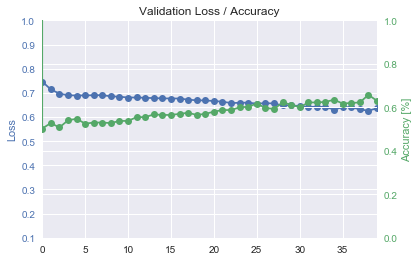

In [33]:
steps, loss, acc = zip(*history)

fig = plt.figure()
plt.title('Validation Loss / Accuracy')
ax_loss = fig.add_subplot(111)
ax_acc = ax_loss.twinx()
plt.xlabel('Training Steps')
plt.xlim(0, max(steps))

ax_loss.plot(steps, loss, '-o', color='C0')
ax_loss.set_ylabel('Loss', color='C0');
ax_loss.tick_params('y', colors='C0')
ax_loss.set_ylim(0.1, 1)

ax_acc.plot(steps, acc, '-o', color='C1')
ax_acc.set_ylabel('Accuracy [%]', color='C1');
ax_acc.tick_params('y', colors='C1')
ax_acc.set_ylim(0,1)

plt.show()

In [34]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    test_accuracy = evaluate(X_valid, y_valid)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.630


In [42]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    feed_dict = {x:test_normalized, keep_prob:1.0}
    classification = sess.run(tf.nn.softmax(y_conv), feed_dict)
    print(classification)

[[ 0.5787515   0.42124847]
 [ 0.67822224  0.32177782]
 [ 0.86215889  0.13784111]
 [ 0.45124736  0.54875261]
 [ 0.3955723   0.6044277 ]
 [ 0.68952036  0.31047967]
 [ 0.64951992  0.35048011]
 [ 0.47548819  0.52451181]
 [ 0.54487234  0.45512769]
 [ 0.72906995  0.27093005]]


cat
cat
cat
dog
dog
cat
cat
dog
cat
cat


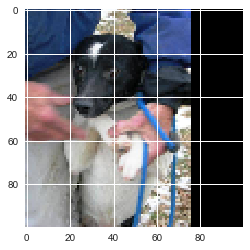

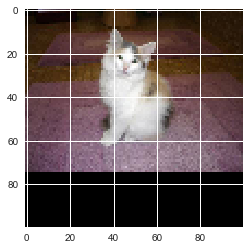

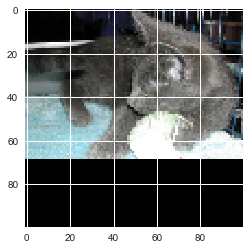

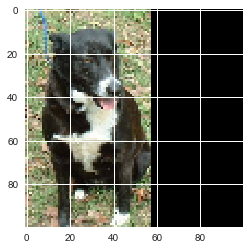

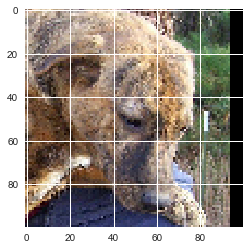

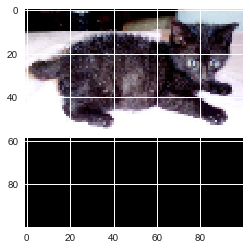

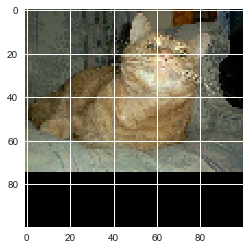

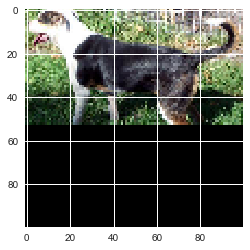

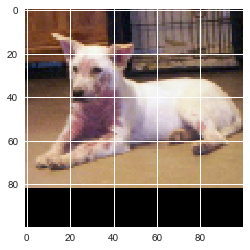

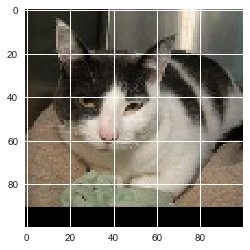

In [65]:
from keras.preprocessing.image import array_to_img
spisok = [0,1,2,3,4,5,6,7,8,9]
for i in spisok:
    plt.imshow (array_to_img(test_normalized[i]))
    plt.figure ()
    if classification[i,0] > classification[i,1]:
        print('cat')
    else:
        print('dog')